### Anderson Impurity Model with Kanamori Interaction

$$
H = \sum_{m,\sigma} \varepsilon_{m0} n_{m0\sigma} + \sum_{m,l,\sigma} \varepsilon_{ml} n_{ml\sigma} + V_{ml} \left( c_{mo\sigma}^\dagger c_{ml\sigma} + h.c. \right) + H_{\rm DD} + H_{\rm SF-PH}
$$

$$
H_{\rm DD} = U \sum_m n_{m0\uparrow}n_{m0\downarrow} + U'\sum_{m'> m }\sum_{\sigma} n_{m0\sigma} n_{m'0\bar{\sigma}} + (U'-J) \sum_{m'>m}\sum_{\sigma} n_{m0\sigma} n_{m'0\sigma}
$$

$$
H_{\rm SF-PH} = \sum_{m'>m} \left[ J\left( c_{m0\uparrow}^\dagger c_{m0\downarrow} c_{m'0\uparrow} c_{m'0\downarrow}^\dagger + h.c. \right) - J\left( c_{m0\uparrow}^\dagger c_{m0\downarrow}^\dagger c_{m'0\uparrow} c_{m'0\downarrow} + h.c. \right) \right]
$$


In [1]:
# Read source code

include("../models/AndersonImpurityModel.jl")
using .AndersonImpurityModel

include("../src/ForkTensorNetworks.jl")
using .ForkTensorNetworks

In [2]:
# Prepare FTNO & Initial FTNS for Anderson Impurity Model
# See reference SciPost Phys. 8, 024 (2020)

N_orb = 2               # Number of orbitals
N_bath = 9              # Number of bath sites
ρ = 0.5                 # Filling of the Impurity model (NOT impurity site)
U = 1.0                 # Coulomb repulsion
J = 0.1                 # Spin-flip, pair-hopping term
U′  = U - 2*J           # Coulomb repulsion for different orbital

εₖ = zeros( 2 * N_orb, N_bath + 1 )
for l=1:(2*N_orb)
    for k=1:N_bath
        εₖ[l,2:(N_bath+1)] = collect(range(-0.8, stop=0.8, length=N_bath))
    end
    εₖ[l,1] = -(3*U - 5*J)/2.
end
Vₖ = 0.1 * ones( 2 * N_orb, N_bath + 1 )


model_params = Dict(
    "model" => "AndersonImpurity",
    "N_orb" => N_orb,
    "N_bath" => N_bath,
    "εₖ" => εₖ,
    "Vₖ" => Vₖ,
    "U" => U,
    "U′" => U′,
    "J" => J,
    "ρ" => ρ,
    "conserve_qns" => true # false: No symmetry, true: U(1)xU(1) symmetry
)

Ws, phys_idx, ftno_aux_x_idx, ftno_aux_y_idx = ftno_aim_model(model_params);
Ts, ftns_aux_x_idx, ftns_aux_y_idx = ftns_initial_state(phys_idx, model_params["ρ"]; conserve_qns=model_params["conserve_qns"]);

In [3]:
#  Running DMRG to get the ground state of the Anderson Impurity Model

Ĥ = ForkTensorNetworkOperator(Ws, phys_idx, ftno_aux_x_idx, ftno_aux_y_idx);
ψ = ForkTensorNetworkState(Ts, phys_idx, ftns_aux_x_idx, ftns_aux_y_idx);

dmrg_params = Dict(
    "method" => "single-site",     # option: "single-site", "two-site"
    "χˣ" => 20,                    # Maximum bond dimension for the backbone
    "χʸ" => 20,                    # Maximum bond dimension for the arm
    "max_iter" => 100,             # Maximum number of DMRG sweeps
    "svd_tol" => 1e-10,            # Threshold for truncating singular values
    "convergence_tol" => 1e-10,    # Threshold for energy convergence
    "verbose" => true,             # Print information during DMRG sweeps
    "subspace_expansion" => true,  # Use subspace expansion or not (Highly recommended for the single-site DMRG)
    "α" => 0.1,                    # subspace expansion parameter
    "α_decay" => 0.5               # Must be less than or equal to 1.0
)

dmrg = DMRG(dmrg_params);
@time E, ψ = run_dmrg!(dmrg, Ĥ, ψ);

* DMRG Parameters:
*  subspace_expansion: true
*  svd_tol: 1.0e-10
*  method: single-site
*  χˣ: 20
*  max_iter: 100
*  α_decay: 0.5
*  verbose: true
*  convergence_tol: 1.0e-10
*  α: 0.1
*  χʸ: 20

Iteration: 1, Energy: -9.2541773827719, δE: 1.0
Iteration: 2, Energy: -10.110425720693536, δE: 0.08468964231339024
Iteration: 3, Energy: -10.135410635597983, δE: 0.002465111262161813
Iteration: 4, Energy: -10.135448893384618, δE: 3.7746514275907976e-6
Iteration: 5, Energy: -10.135449088245268, δE: 1.922565528035386e-8
Iteration: 6, Energy: -10.13544911894222, δE: 3.0286719807718763e-9
Iteration: 7, Energy: -10.135449154134093, δE: 3.4721573527118667e-9
Iteration: 8, Energy: -10.135449164936235, δE: 1.0657782627885583e-9
Iteration: 9, Energy: -10.135449166187511, δE: 1.2345544783440962e-10
Iteration: 10, Energy: -10.13544916987586, δE: 3.6390584371850996e-10
Iteration: 11, Energy: -10.13544917247124, δE: 2.5606955023117887e-10
Iteration: 12, Energy: -10.1354491732256, δE: 7.442789333010996e-

In [4]:
tdvp_params = Dict(
    "method" => "single-site",   # option: "single-site", "two-site"
    "χˣ" => 30,                  # Maximum bond dimension for the backbone
    "χʸ" => 30,                  # Maximum bond dimension for the arm
    "verb_level" => 0,           # Print information during TDVP sweeps (0: no print, 1: print params, 2: print details)
    "δt" => 0.10,                # Time step
    "Ncut" => 10,                # Maximum number of Kyrlov vectors used in the Kylov exponentiation
)

tdvp = TDVP(tdvp_params);
ψₜ = deepcopy(ψ);
ψ′ = deepcopy(ψ);
applying_local_operators!(ψₜ, [(1, 1, "c†")])
applying_local_operators!(ψ′, [(1, 1, "c†")])

Gₜ = [overlap_ftn(ψ′, ψₜ) * exp(1im * E * tdvp.time)]
Gₜ′ = [overlap_ftn(ψ′, ψₜ)* exp(1im * E * tdvp.time)]
Ts = [0.0]

for i = 1:150
    run_tdvp!(tdvp, Ĥ, ψₜ, 1)
    auto_corr = overlap_ftn(ψ′, ψₜ)
    append!(Gₜ, auto_corr * exp(-1im * E * tdvp.time))
    append!(Gₜ′, auto_corr)
    append!(Ts, tdvp.time)
end


* TDVP Parameters:
*  δt: 0.1
*  method: single-site
*  χˣ: 30
*  Ncut: 10
*  verb_level: 0
*  χʸ: 30



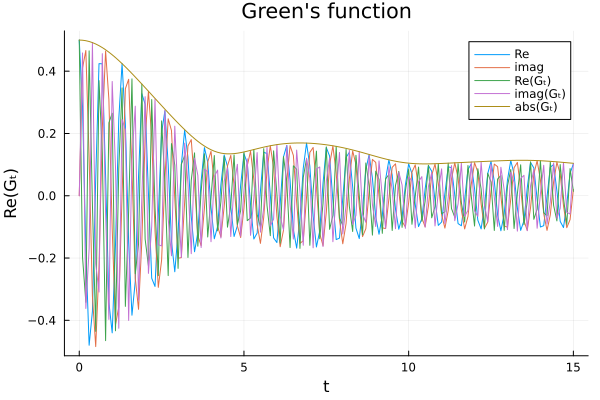

In [5]:
using Plots
plot(Ts, real(Gₜ′), xlabel="t", ylabel="Re(Gₜ)", title="Green's function", label="Re(Gₜe^{-iEt})")
plot!(Ts, imag(Gₜ′), xlabel="t", ylabel="Re(Gₜ)", title="Green's function", label="imag(Gₜe^{-iEt})")
plot!(Ts, real(Gₜ), xlabel="t", ylabel="Re(Gₜ)", title="Green's function", label="Re(Gₜ)")
plot!(Ts, imag(Gₜ), xlabel="t", ylabel="Re(Gₜ)", title="Green's function", label="imag(Gₜ)")
plot!(Ts, abs.(Gₜ), xlabel="t", ylabel="Re(Gₜ)", title="Green's function", label="abs(Gₜ)")